# Switchpoint example


You can install PyMC3 with

```conda install pymc3```

In [7]:
import os,sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as st

%matplotlib inline
%precision 4
plt.style.use('bmh')

## Switchpoint analysis

This example comes from [Cam Davidson-Pilon's book](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

We will be looking at count data---specifically at the frequency of text messages recieved over a period of time.  We will use the Poisson distribution to help use investigate this series of events.

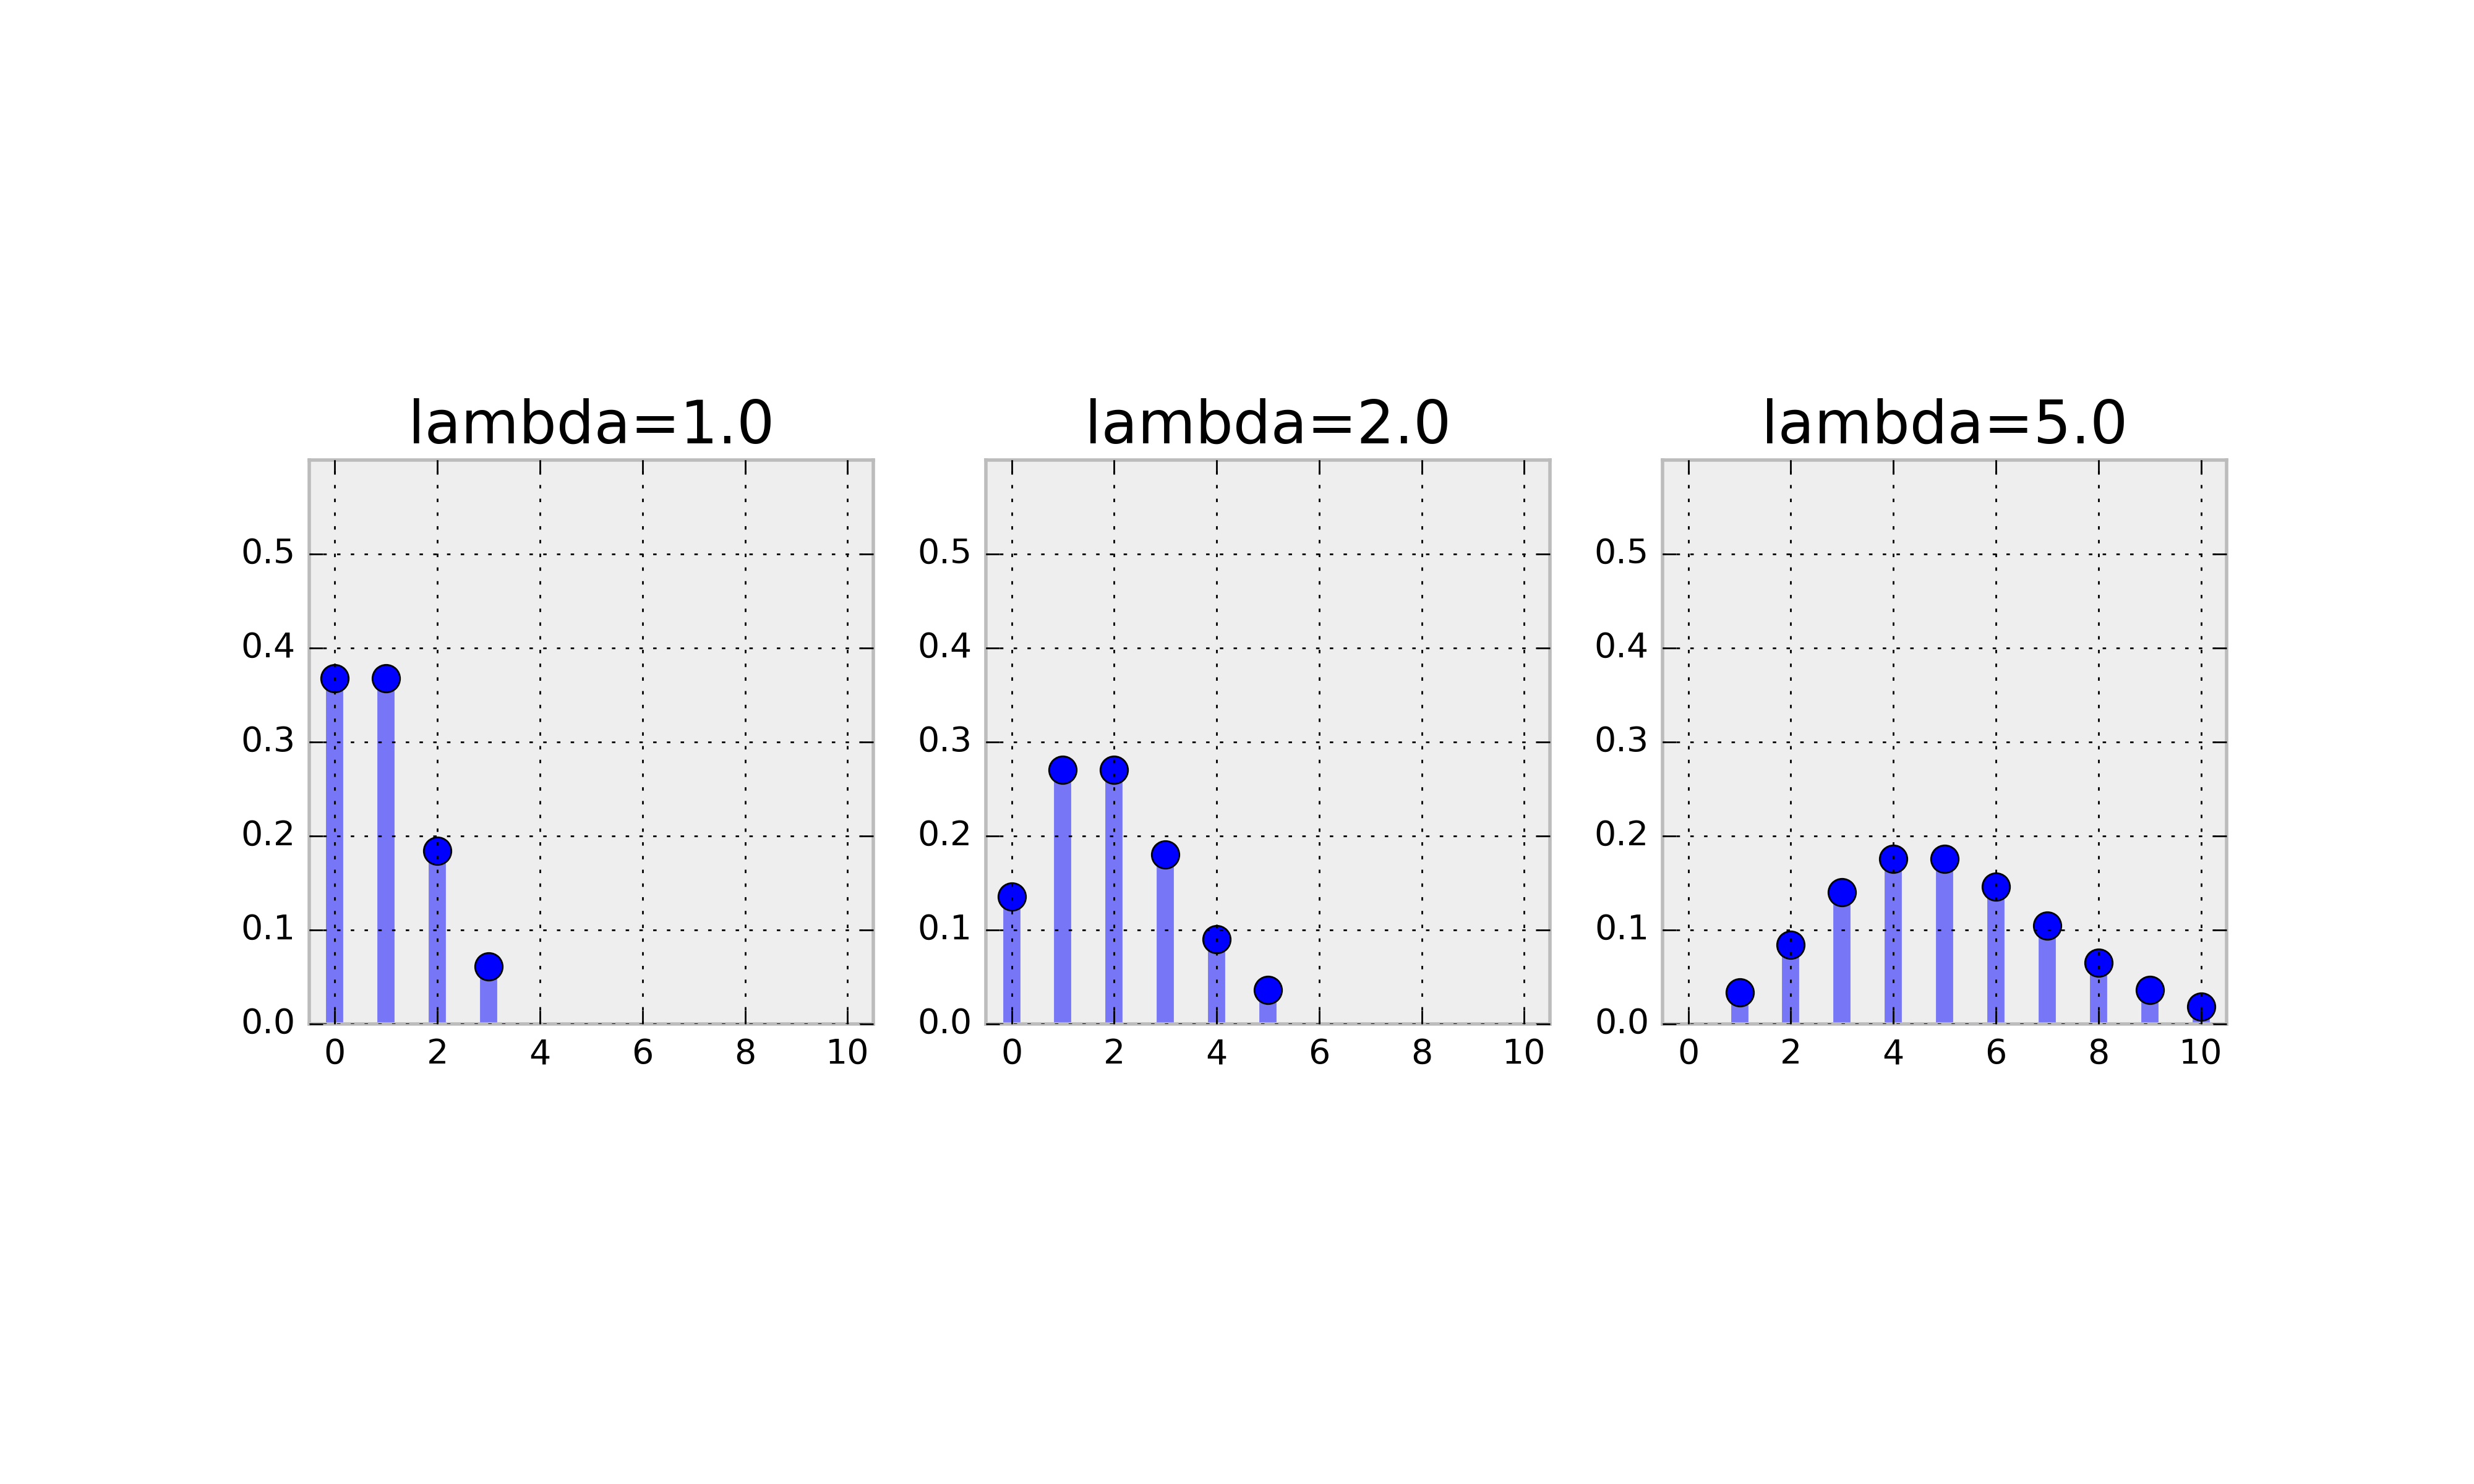

In [2]:
from IPython.display import Image
Image(filename='./images/poisson.png')

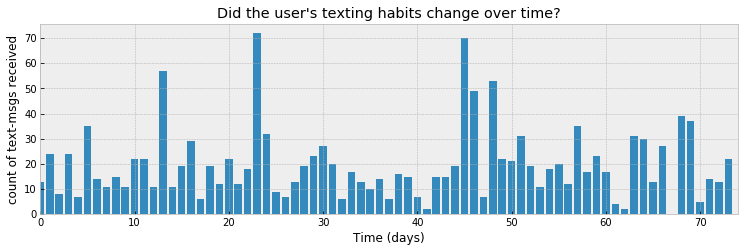

In [3]:
fig = plt.figure(figsize=(12.5, 3.5))
ax = fig.add_subplot(111)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
ax.bar(np.arange(n_count_data), count_data, color="#348ABD")
ax.set_xlabel("Time (days)")
ax.set_ylabel("count of text-msgs received")
ax.set_title("Did the user's texting habits change over time?")
ax.set_xlim(0, n_count_data);

These are time-course data.  Can we infer when a behavioral change occurred?

Lets denote the day with $i$ and text-message count by $C_i$,

$$ C_i \sim \text{Poisson}(\lambda) $$

   * Does the rate $\lambda$ change?
   * Is there a day (call it $\tau$) where the parameter $\lambda$ suddenly jumps to a higher value?
   * We are looking for a _switchpoint_ s.t.

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

If no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. We are using Bayesian inference so we need priors. The *exponential* distribution provides a continuous density function for positive numbers.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

$\alpha$ is a *hyper-parameter*. In literal terms, it is a parameter that influences other parameters.

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 

What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

So what does this look like in PyMC3?

In [4]:
import pymc3 as pm
import theano.tensor as tt

## assign lambdas and tau to stochastic variables
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

## create a combined function for lambda (it is still a RV)    
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

## combine the data with our proposed data generation scheme    
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

## inference
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6275.31draws/s]
The number of effective samples is smaller than 25% for some parameters.


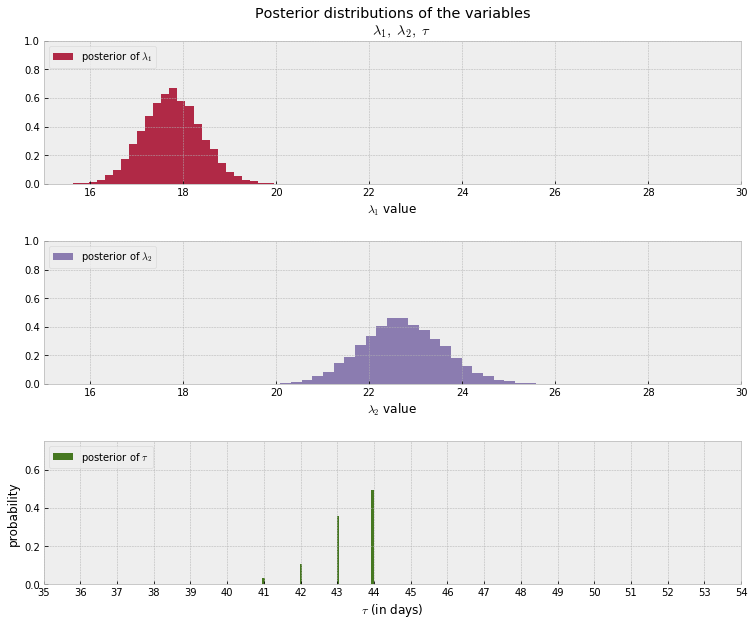

In [5]:
## get the variables we want to plot from our trace
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

# draw histogram of the samples:
fig = plt.figure(figsize=(12.5,10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for ax in [ax1,ax2]:
    ax.set_autoscaley_on(False)

## axis 1    
ax1.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
ax1.legend(loc="upper left")
ax1.set_title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
ax1.set_xlim([15, 30])
ax1.set_xlabel("$\lambda_1$ value")

## axis 2
ax2.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
ax2.legend(loc="upper left")
ax2.set_xlim([15, 30])
ax2.set_xlabel("$\lambda_2$ value")

## axis 3
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
ax3.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
ax3.set_xticks(np.arange(n_count_data))

ax3.legend(loc="upper left")
ax3.set_ylim([0, .75])
ax3.set_xlim([35, len(count_data)-20])
ax3.set_xlabel(r"$\tau$ (in days)")
ax3.set_ylabel("probability");
plt.subplots_adjust(hspace=0.4)

### How do we plot the expection distribution of this model?

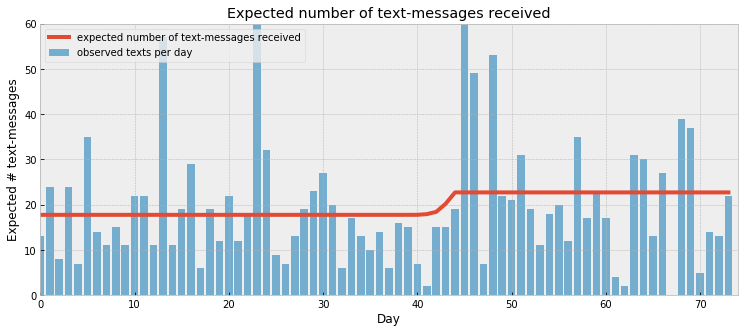

In [6]:
fig = plt.figure(figsize=(12.5,5))
ax = fig.add_subplot(111)

N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

ax.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
ax.set_xlim(0, n_count_data)
ax.set_xlabel("Day")
ax.set_ylabel("Expected # text-messages")
ax.set_title("Expected number of text-messages received")
ax.set_ylim(0, 60)
ax.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,label="observed texts per day")

ax.legend(loc="upper left");

A distribution allows us to see the uncertainty in our estimates.  The two distribution for $\lambda$ are distinct.  Near day 45, there was a 50% chance that the user's behavior changed.

> In fact, the 45th day corresponds to Christmas, and I moved away to Toronto the next month, leaving a girlfriend behind

      -Cam Davidson Pilon
